In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
# from sklearn.svm import SVC

# DataFrame Sampling : CoRace

In [3]:
# df = pd.read_csv('../Data/Cleaned_data.csv')
df = pd.read_csv('../Data/Cleaned_data_Inflation_Adjusted_.csv')
print(df['CoRace'].value_counts())

df = df[df['CoRace'] != 4]
min_count = df['CoRace'].value_counts().min()
df = df.groupby('CoRace').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
print(df['CoRace'].value_counts())

CoRace
5    370968
8    269075
7     15857
6      9927
2      9438
3      3667
1      1368
4       567
Name: count, dtype: int64
CoRace
1    1368
2    1368
3    1368
5    1368
6    1368
7    1368
8    1368
Name: count, dtype: int64


# train_test_split


Training/Testing Split: 70%/30%

Model: ZeroR
 Accuracy: 0.1371, Precision: 0.8767, Recall: 0.1429, F1-Score: 0.0345, Specificity: 0.8571
Time taken: 0.01 seconds

Model: Random Forest
 Accuracy: 0.6297, Precision: 0.6460, Recall: 0.6333, F1-Score: 0.6346, Specificity: 0.9382
Time taken: 1.06 seconds

Model: Decision Tree
 Accuracy: 0.5517, Precision: 0.5552, Recall: 0.5559, F1-Score: 0.5554, Specificity: 0.9252
Time taken: 0.08 seconds

Model: Extra Trees
 Accuracy: 0.6123, Precision: 0.6271, Recall: 0.6161, F1-Score: 0.6185, Specificity: 0.9353
Time taken: 0.54 seconds

Model: Gradient Boosting
 Accuracy: 0.6401, Precision: 0.6620, Recall: 0.6433, F1-Score: 0.6475, Specificity: 0.9399
Time taken: 12.32 seconds



c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:34:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: Logistic Regression
 Accuracy: 0.2576, Precision: 0.2398, Recall: 0.2602, F1-Score: 0.2342, Specificity: 0.8764
Time taken: 0.89 seconds

Model: XGBoost
 Accuracy: 0.6328, Precision: 0.6449, Recall: 0.6361, F1-Score: 0.6384, Specificity: 0.9387
Time taken: 0.51 seconds

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 6703, number of used features: 28
[LightGBM] [Info] Start training from score -1.955956
[LightGBM] [Info] Start training from score -1.931984
[LightGBM] [Info] Start training from score -1.969764
[LightGBM] [Info] Start training from score -1.955956
[LightGBM] [Info] Start training from score -1.928899
[LightGBM] [Info] Start training from score -1.948599
[LightGBM] [Info] Start traini

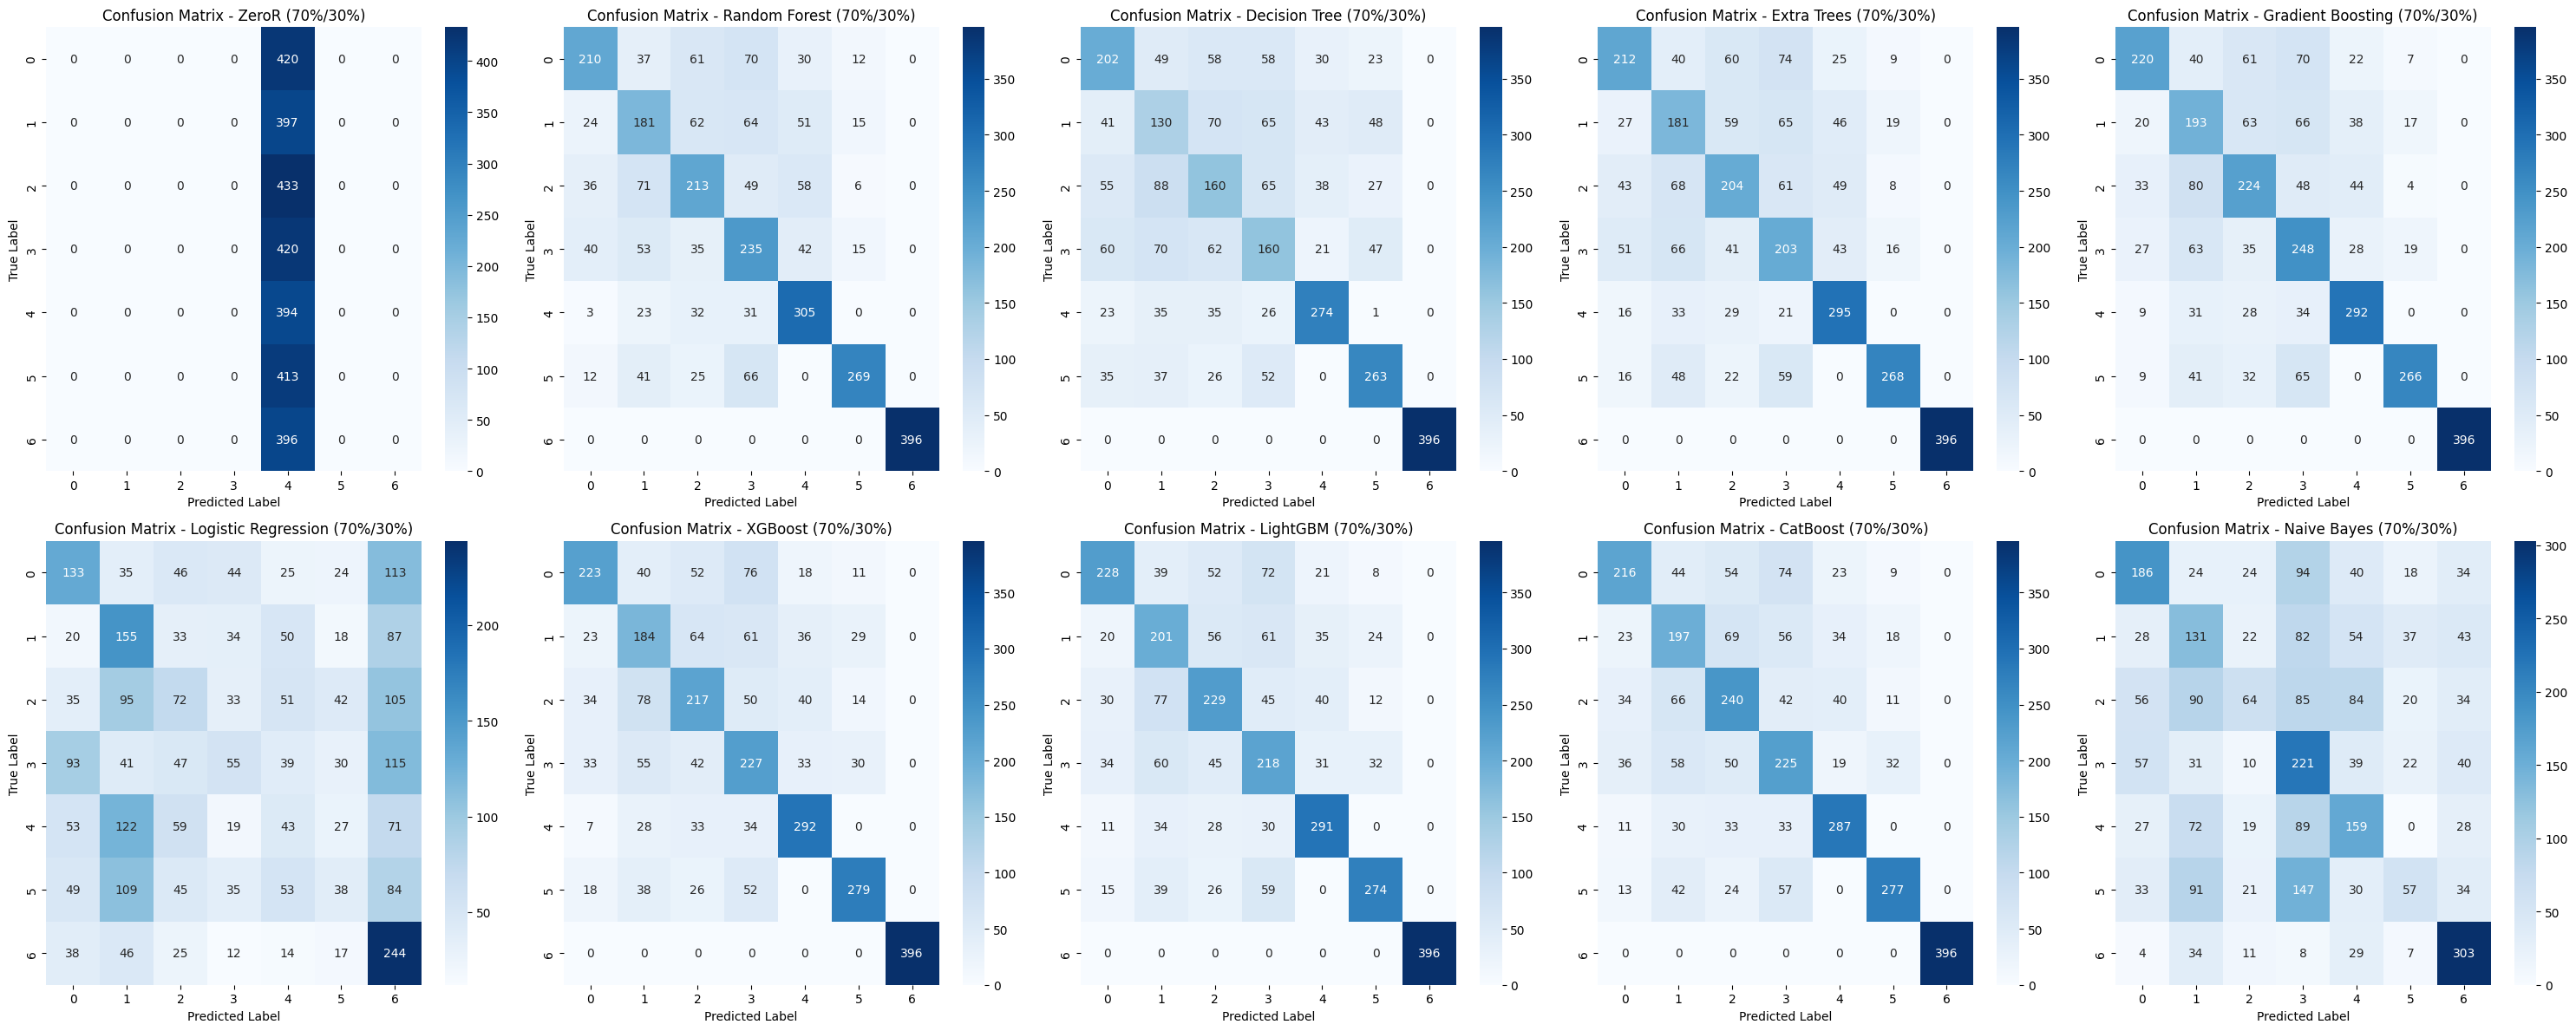

In [4]:
results_dir = "CoRace_SPLITS"
os.makedirs(results_dir, exist_ok=True)

X = df.drop(columns=["BoRace", "CoRace"])
y = df["CoRace"]

# splits = [(0.90, 0.10), (0.80, 0.20), (0.70, 0.30)]
train_size = 0.70
test_size = 0.30

models = {
    "ZeroR": DummyClassifier(strategy="most_frequent"),
    # "SGD Classifier": SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42), 
    # "KNN": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Naive Bayes": GaussianNB(),
    # models["SVM"] = SVC(probability=True, random_state=42)
}


def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diag(cm)  # True Negatives per class
    fp = np.sum(cm, axis=0) - np.diag(cm)  # False Positives per class
    specificity_per_class = tn / (tn + fp)  # Compute specificity per class
    return np.mean(specificity_per_class)  # Return the average specificity

train_percent = int(train_size * 100)
test_percent = int(test_size * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
print(f"\nTraining/Testing Split: {train_percent}%/{test_percent}%\n")

results = {}
conf_matrices = {}
for name, model in models.items():
    start_time = time.time()
    
    if name == "XGBoost":
        le = LabelEncoder()
        y_train_enc = le.fit_transform(y_train)
        y_test_enc = le.transform(y_test)
        model.fit(X_train, y_train_enc)
        y_pred = le.inverse_transform(model.predict(X_test))

    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=1)
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    spec = specificity_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    elapsed_time = time.time() - start_time
    
    results[name] = {
        "Accuracy": acc, 
        "Precision": prec, 
        "Recall": rec, 
        "F1-Score": f1, 
        "Specificity": spec,
        "Total Runtime (s)": elapsed_time,
    }
    conf_matrices[name] = cm
    print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
    print("Time taken: {:.2f} seconds\n".format(elapsed_time))
    
results_df = pd.DataFrame(results).T
results_file = f"{results_dir}/results_split_{train_percent}_{test_percent}.csv"
results_df.to_csv(results_file, index=True)
print(f"Results saved to {results_file}")

for name, cm in conf_matrices.items():
    cm_file = f"{results_dir}/conf_matrix_{train_percent}_{test_percent}_{name.replace(' ', '_')}.csv"
    pd.DataFrame(cm).to_csv(cm_file, index=False)
    print(f"Confusion Matrix for {name} saved to {cm_file}")

fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name} ({train_percent}%/{test_percent}%)')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [8]:
from interpret.glassbox import ExplainableBoostingClassifier
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)
from interpret import show
ebm_global = ebm.explain_global()
show(ebm_global)

c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1173: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


<!-- http://127.0.0.1:7001/1899559377296/ -->

# cross_val_predict

In [5]:
def cross_val_predict_xgb(model, X, y, cv):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_pred_all = np.zeros_like(y_encoded)

    for train_idx, test_idx in cv.split(X, y_encoded):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        model.fit(X_train, y_train)
        y_pred_fold = model.predict(X_test)
        y_pred_all[test_idx] = y_pred_fold

    y_pred_final = le.inverse_transform(y_pred_all)
    return y_pred_final


Performing 5-fold cross-validation

Model: ZeroR
 Accuracy: 0.1425, Precision: 0.6325, Recall: 0.1425, F1-Score: 0.0838, Specificity: 0.8571
Time taken: 0.01 seconds
Time taken: 0.00 minutes

Model: Random Forest
 Accuracy: 0.5833, Precision: 0.5913, Recall: 0.5833, F1-Score: 0.5786, Specificity: 0.9306
Time taken: 5.97 seconds
Time taken: 0.10 minutes

Model: Decision Tree
 Accuracy: 0.5146, Precision: 0.5109, Recall: 0.5146, F1-Score: 0.5121, Specificity: 0.9191
Time taken: 0.42 seconds
Time taken: 0.01 minutes

Model: Extra Trees
 Accuracy: 0.5641, Precision: 0.5677, Recall: 0.5641, F1-Score: 0.5590, Specificity: 0.9274
Time taken: 2.88 seconds
Time taken: 0.05 minutes

Model: Gradient Boosting
 Accuracy: 0.6029, Precision: 0.6160, Recall: 0.6029, F1-Score: 0.6011, Specificity: 0.9338
Time taken: 69.25 seconds
Time taken: 1.15 minutes



c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Model: Logistic Regression
 Accuracy: 0.2391, Precision: 0.2197, Recall: 0.2391, F1-Score: 0.2167, Specificity: 0.8732
Time taken: 4.81 seconds
Time taken: 0.08 minutes



c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "

Model: XGBoost
 Accuracy: 0.5828, Precision: 0.5823, Recall: 0.5828, F1-Score: 0.5772, Specificity: 0.9305
Time taken: 2.01 seconds
Time taken: 0.03 minutes

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3203
[LightGBM] [Info] Number of data points in the train set: 7660, number of used features: 28
[LightGBM] [Info] Start training from score -1.946171
[LightGBM] [Info] Start training from score -1.946171
[LightGBM] [Info] Start training from score -1.945258
[LightGBM] [Info] Start training from score -1.946171
[LightGBM] [Info] Start training from score -1.945258
[LightGBM] [Info] Start training from score -1.946171
[LightGBM] [Info] Start training from score -1.946171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

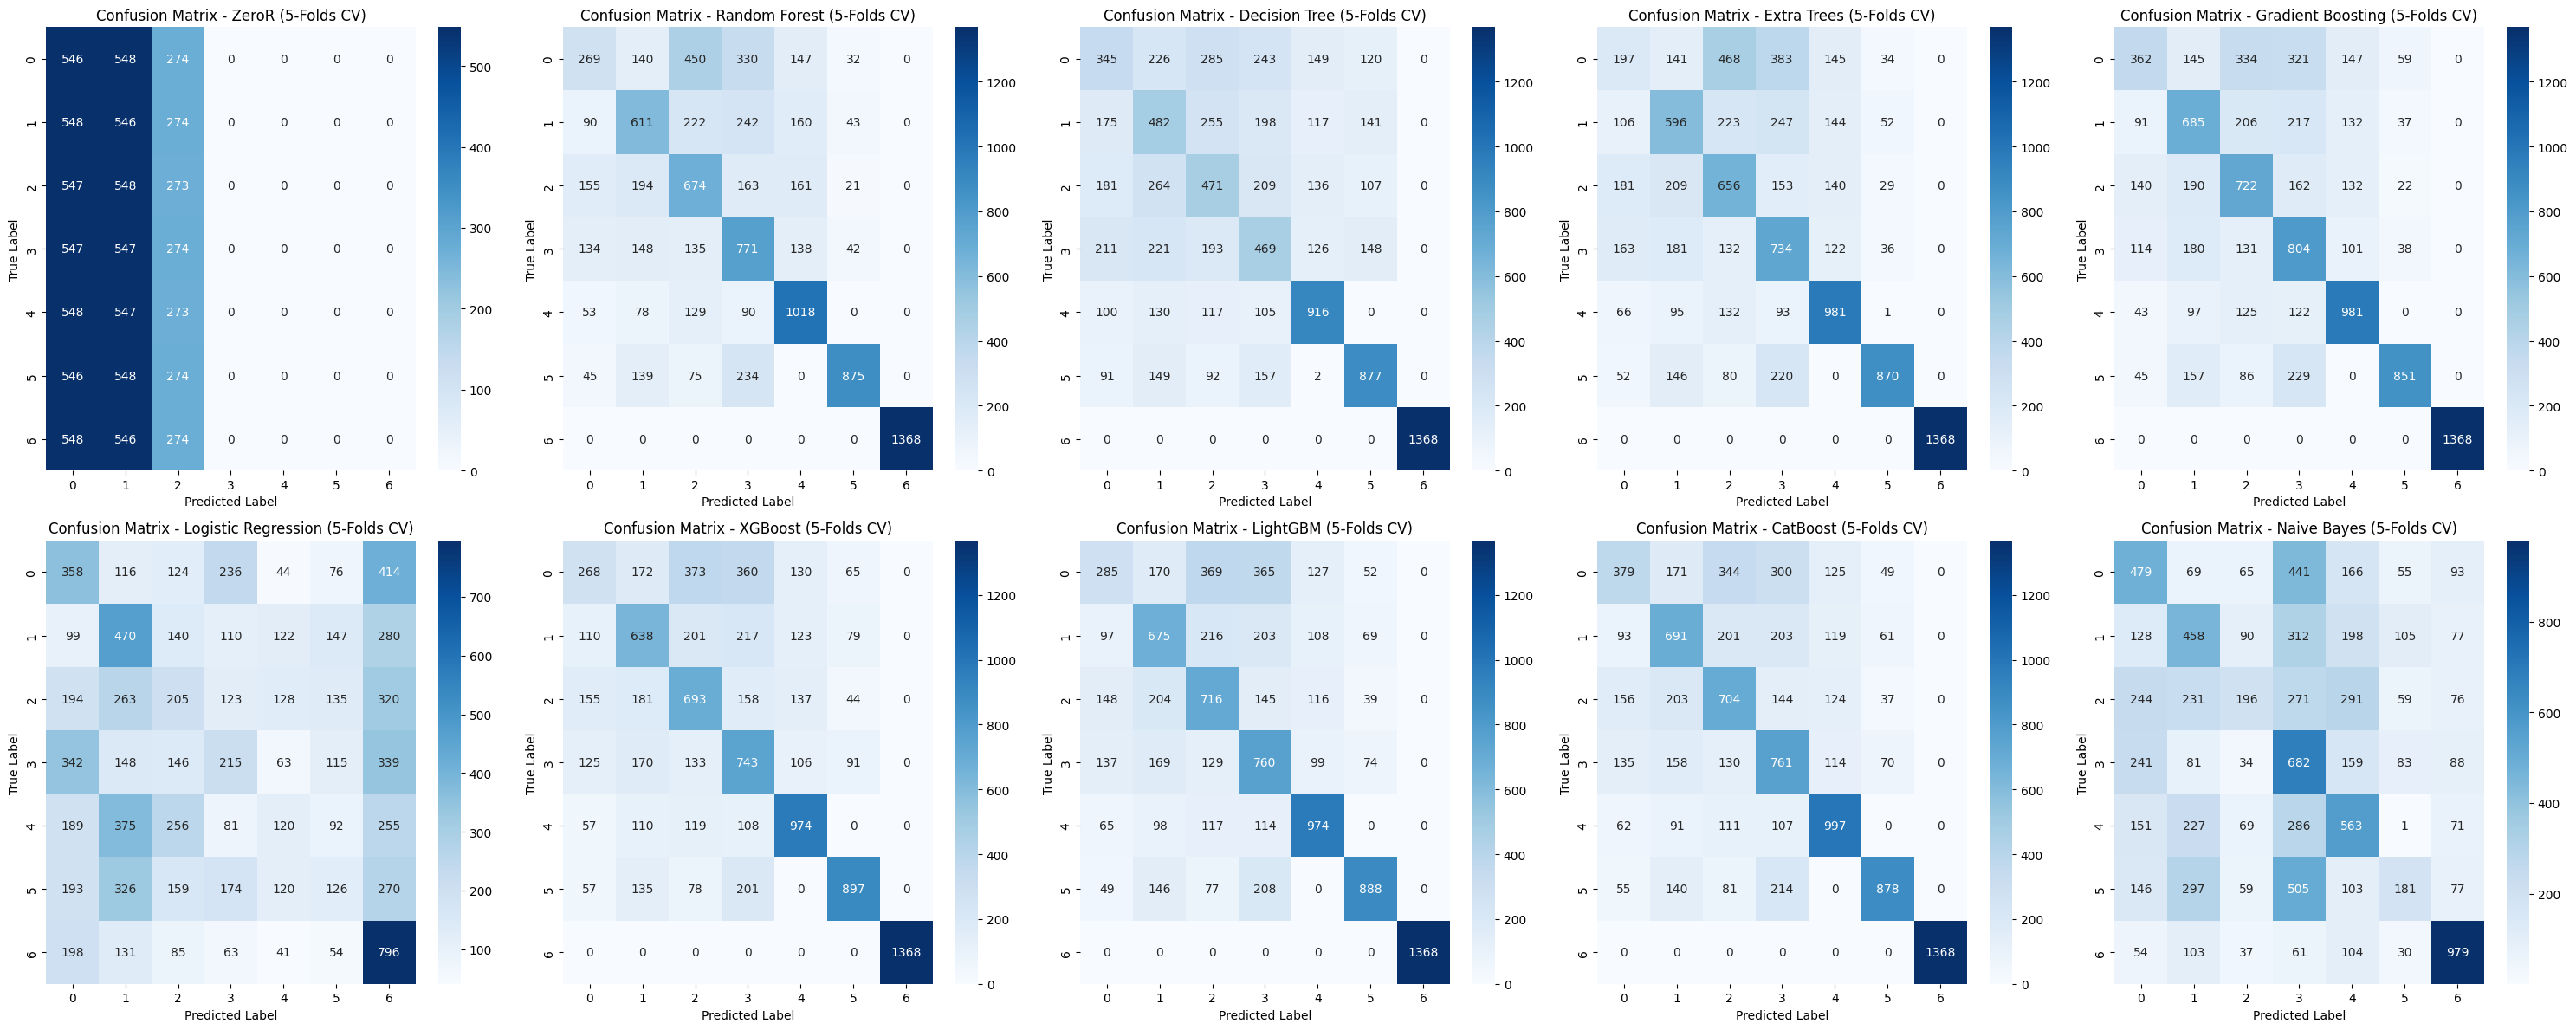

In [6]:
cv_results_dir = "CoRace_CV"
os.makedirs(cv_results_dir, exist_ok=True)

X = df.drop(columns=["BoRace", "CoRace"])
y = df["CoRace"]

# folds_list = [5]
num_folds = 5

models = {
    "ZeroR": DummyClassifier(strategy="most_frequent"),
    # "SGD Classifier": SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42), 
    # "KNN": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Naive Bayes": GaussianNB(),
    # models["SVM"] = SVC(probability=True, random_state=42)
}

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diag(cm)  # True Negatives per class
    fp = np.sum(cm, axis=0) - np.diag(cm)  # False Positives per class
    specificity_per_class = tn / (tn + fp)  # Compute specificity per class
    return np.mean(specificity_per_class)  # Return the average specificity

# for num_folds in folds_list:
print(f"\nPerforming {num_folds}-fold cross-validation\n")
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

results = {}
conf_matrices = {}

for name, model in models.items():
    start_time = time.time()

    if name == "XGBoost":
        y_pred = cross_val_predict_xgb(model, X, y, cv=kf)
    else:
        y_pred = cross_val_predict(model, X, y, cv=kf)

    total_runtime = time.time() - start_time
    
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=1)
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    spec = specificity_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    
    results[name] = {
        "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1,
        "Specificity": spec, "Total Runtime (s)": total_runtime, "Total Runtime (min)": total_runtime / 60
    }
    
    conf_matrices[name] = cm
    
    print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
    print("Time taken: {:.2f} seconds".format(total_runtime))
    print("Time taken: {:.2f} minutes\n".format(total_runtime / 60))

results_df = pd.DataFrame(results).T
results_file = f"{cv_results_dir}/results_cv_{num_folds}_folds.csv"
results_df.to_csv(results_file, index=True)
print(f"Results saved to {results_file}")

for name, cm in conf_matrices.items():
    cm_file = f"{cv_results_dir}/conf_matrix_cv_{num_folds}_folds_{name.replace(' ', '_')}.csv"
    pd.DataFrame(cm).to_csv(cm_file, index=False)
    print(f"Confusion Matrix for {name} saved to {cm_file}")

fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name} ({num_folds}-Folds CV)')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()


# Feature Selection

In [7]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def run_rfecv(model, df, target_col='CoRace', scoring='accuracy', results_dir="CoRace_RFECV"):
    model_name = type(model).__name__
    
    X = df.drop(columns=[target_col, "BoRace"])
    y = df[target_col]

    selector = RFECV(
        estimator=model,
        step=1,
        cv=StratifiedKFold(5),
        scoring=scoring,
        n_jobs=-1
    )

    selector.fit(X, y)

    selected_features = X.columns[selector.support_]
    try:
        importances = selector.estimator_.feature_importances_
    except AttributeError:
        try:
            importances = np.abs(selector.estimator_.coef_).flatten()
        except AttributeError:
            importances = np.zeros(len(selected_features))

    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    importance_csv_path = os.path.join(results_dir, f"{model_name}_rfecv_importances.csv")
    importance_df.to_csv(importance_csv_path, index=False)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1),
             selector.cv_results_['mean_test_score'], marker='o')
    plt.xlabel("Number of Selected Features")
    plt.ylabel(f"CV Score ({scoring})")
    plt.title(f"RFECV - {model_name}")
    plt.grid(True)
    plt.tight_layout()
    plot_path = os.path.join(results_dir, f"{model_name}_rfecv_plot.png")
    plt.savefig(plot_path)
    plt.close()
    
    print(f"{model_name}: Best {selector.n_features_} features selected. Results saved to {importance_csv_path}")

results_dir = "CoRace_RFECV"
os.makedirs(results_dir, exist_ok=True)

X = df.drop(columns=["CoRace", "CoRace"])
y = df["CoRace"]


models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    ExtraTreesClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42), 
    LGBMClassifier(random_state=42),
    CatBoostClassifier(verbose=0, random_state=42),
]

for model in models:
    run_rfecv(model, df=df)

RandomForestClassifier: Best 25 features selected. Results saved to CoRace_RFECV\RandomForestClassifier_rfecv_importances.csv
ExtraTreesClassifier: Best 24 features selected. Results saved to CoRace_RFECV\ExtraTreesClassifier_rfecv_importances.csv
GradientBoostingClassifier: Best 27 features selected. Results saved to CoRace_RFECV\GradientBoostingClassifier_rfecv_importances.csv
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3244
[LightGBM] [Info] Number of data points in the train set: 9576, number of used features: 28
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[Light

# Fairness Analysis : LightGBM

In [22]:
import pandas as pd

model_scroes = pd.read_csv('CoRace_CV/results_cv_5_folds.csv')
model_scroes[['Unnamed: 0', 'Accuracy','Total Runtime (s)']].sort_values(by='Accuracy', ascending=False).head()

,Unnamed: 0,Accuracy,Total Runtime (s)
8,CatBoost,0.603383,24.979322
4,Gradient Boosting,0.602861,69.251777
7,LightGBM,0.591688,1.776603
1,Random Forest,0.583333,5.968225
6,XGBoost,0.582811,2.009432


c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\preprocessing\_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class 

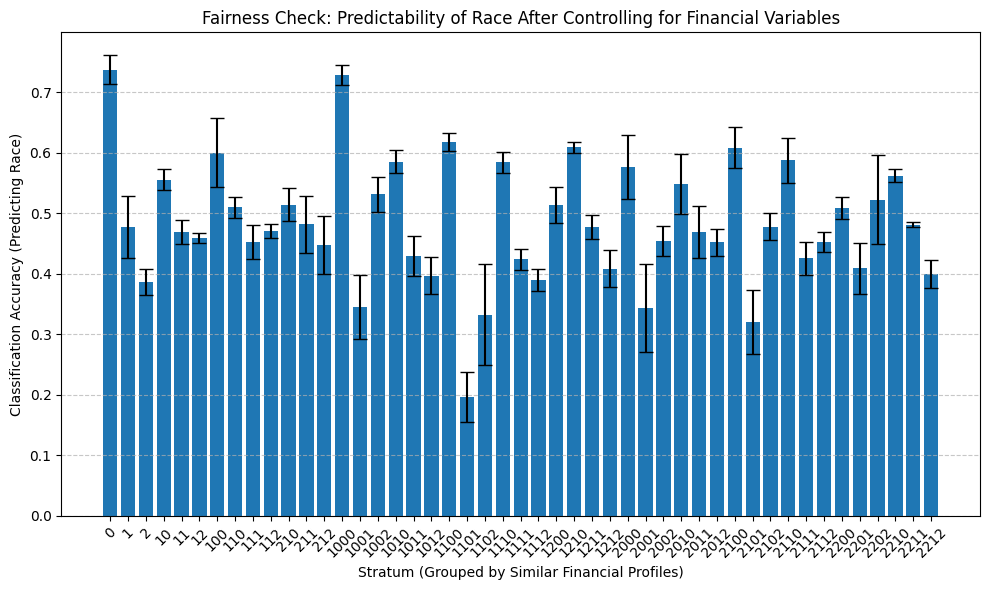

In [40]:
control_vars = ['Income_adjusted', 'Borrower Credit Score', 'Front', 'Back']
target = 'CoRace'

df_clean = df.dropna(subset=control_vars + [target])

# Stratify using KBinsDiscretizer (quantile binning)
binning = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
binned_controls = binning.fit_transform(df_clean[control_vars])
strata_labels = pd.Series(np.sum(binned_controls * (10 ** np.arange(binned_controls.shape[1])), axis=1), name="Stratum")

df_clean['Stratum'] = strata_labels
results = []

for stratum, group in df_clean.groupby('Stratum'):
    if group[target].nunique() < 2 or len(group) < 30:
        continue  # Skip strata that lack enough diversity or samples

    X = group.drop(columns=[target, 'Stratum'])
    y = group[target]

    # Drop protected attributes from predictors
    X = X.drop(columns=['BoGender', 'CoGender', 'BoRace'], errors='ignore')

    model = CatBoostClassifier(verbose=0, random_state=42)
    scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')

    results.append({
        'Stratum': str(int(stratum)),  # For readable x-axis
        'Samples': len(group),
        'Mean Accuracy': np.mean(scores),
        'Std Error': np.std(scores, ddof=1) / np.sqrt(len(scores)),
        'Std Dev': np.std(scores),
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# === Plot the results ===
plt.figure(figsize=(10, 6))
plt.bar(results_df['Stratum'], results_df['Mean Accuracy'], yerr=results_df['Std Error'], capsize=5)
plt.xlabel("Stratum (Grouped by Similar Financial Profiles)")
plt.ylabel("Classification Accuracy (Predicting Race)")
plt.title("Fairness Check: Predictability of Race After Controlling for Financial Variables")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Bin 0 ≈ low (0–33%)

Bin 1 ≈ medium (33–66%)

Bin 2 ≈ high (66–100%)

In [42]:
results_df['Stratum'] = results_df['Stratum'].astype(int)
bin_df = pd.DataFrame(binned_controls, columns=[f"{var}_bin" for var in control_vars])
df_strata = pd.concat([df_clean.reset_index(drop=True), bin_df], axis=1)
df_strata["Stratum"] = np.sum(binned_controls * (10 ** np.arange(binned_controls.shape[1])), axis=1)
decoded = df_strata.groupby("Stratum")[[f"{var}_bin" for var in control_vars]].first().reset_index()
results_with_bins = results_df.merge(
    df_strata.groupby("Stratum")[[f"{var}_bin" for var in control_vars]].first().reset_index(),
    on="Stratum", how="left"
)
results_with_bins.to_csv('CoRace_Fairness.csv', index=False)
results_with_bins

,Stratum,Samples,Mean Accuracy,Std Error,Std Dev,Income_adjusted_bin,Borrower Credit Score_bin,Front_bin,Back_bin
0,0,80,0.737500,0.023385,0.046771,0.0,0.0,0.0,0.0
1,1,61,0.476923,0.051146,0.102291,1.0,0.0,0.0,0.0
2,2,57,0.386364,0.021694,0.043387,2.0,0.0,0.0,0.0
3,10,234,0.555597,0.017963,0.035926,0.0,1.0,0.0,0.0
4,11,533,0.469177,0.020244,0.040487,1.0,1.0,0.0,0.0
5,12,940,0.458511,0.007961,0.015922,2.0,1.0,0.0,0.0
6,100,45,0.600000,0.056656,0.113312,0.0,0.0,1.0,0.0
7,110,261,0.509507,0.017170,0.034341,0.0,1.0,1.0,0.0
8,111,354,0.452032,0.028014,0.056028,1.0,1.0,1.0,0.0
9,112,370,0.470270,0.011625,0.023250,2.0,1.0,1.0,0.0
